## Objective

Sentiment analysis is a common use case of NLP where the idea is to classify the tweet as positive, negative or neutral depending upon the text in the tweet. This problem goes a way ahead and expects us to also determine the words in the tweet which decide the polarity of the tweet.

## Understanding the Evaluation Metric

The metric in this competition is the word-level **Jaccard score**. Jaccard Score is a measure of how similar/dissimilar two sets are.  The higher the score, the more similar the two strings. The idea is to find the number of common tokens and divide it by the total number of unique tokens. Its expressed in the mathematical terms by,

![](https://imgur.com/lMHa8CL.png)

![](https://images.deepai.org/glossary-terms/jaccard-index-391304.jpg)

[Source](https://en.wikipedia.org/wiki/Jaccard_index)

Here is a great example to understand the Jaccard Similarity Metric in an inutitve way.Refer to the main blog for more details:[FIVE MOST POPULAR SIMILARITY MEASURES IMPLEMENTATION IN PYTHON](https://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/)

![](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2015/04/jaccaard2.png?resize=768%2C307&ssl=1)

**Here is how one can implement the jaccard score in Python:**

In [1]:

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


Sentence_1 = 'Life well spent is life good'
Sentence_2 = 'Life is an art and it is good so far'
Sentence_3 = 'Life is good'

    
print(jaccard(Sentence_1,Sentence_2))
print(jaccard(Sentence_1,Sentence_3))

0.2727272727272727
0.6


Let's now begin with the Exploratory data analysis. Let's quickly go over the Table of contents to get an idea what we shall be covering in this notebook:

# Table of Contents

- 1. Dataset and Dependencies
   - 1.1 Importing the necessary libraries
   - 1.2 Reading in the Dataset
- 2. General EDA
   - 2.1 Missing Vales
- 3. Analysis of the Sentiment Column
   - 3.1 An example of each sentiment
   - 3.2 Distribution of the Sentiment column
- 4. Text Data Preprocessing
- 5. Text Statistics
   - 5.1 Sentence Length
   - 5.2 Word Count
   - 5.3 Word Frequency
- 6. Ngram Analysis
- 7. Exploring the selected_text column
- 8  Wordclouds
- 9. Extracting the sentiment terms : Resources
  

# 1. Datasets & Dependencies
## 1.1 Importing the necessary libraries

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords


# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# File system manangement
import os

# Pytorch
import torch

#Transformers
from transformers import BertTokenizer

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [9]:
os.listdir('twitter/')

['test.csv', 'train.csv', 'sample_submission.csv']

## 1.2 Reading the datasets

In [10]:
#Training data
train = pd.read_csv('twitter/train.csv')
test = pd.read_csv('twitter/test.csv')
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

# First few rows of the training dataset
train.head()

# First few rows of the testing dataset
test.head()

Training data shape:  (27481, 4)
Testing data shape:  (3534, 3)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


The columns denote the following:

* The `textID` of a tweet
* The `text` of a tweet
* The `selected text` which determines the polarity of the tweet
* `sentiment` of the tweet

The test dataset doesn't have the selected text column which needs to be identified.

# 2. General EDA
## 2.1 Missing Values treatment in the dataset


In [11]:
#Missing values in training set
train.isnull().sum()
#Missing values in test set
test.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

textID       0
text         0
sentiment    0
dtype: int64

The `text` and `selected_text` column have one row missing each. Let's get rid of the missing rows.

In [12]:
# Dropping missing values
train.dropna(axis = 0, how ='any',inplace=True) ;
  

# 3 Analysis of the Sentiment Column

Now, let's analyse and see how the `Sentiment` column looks like. I have only used the training dataset but the process will remain the same if we wish to to do it for the test dataset as well.

## 3.1 Examples of each sentiment
Let's look at an example of each sentiment: Positive, negative and neutral

In [13]:
# Positive tweet
print("Positive Tweet example :",train[train['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",train[train['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


## 3.2 Distribution of the Sentiment Column

In [14]:
train['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

It'll be better if we could get a relative percentage instead of the count. It is very simple with `value_counts` and can be achieved with a minor modification in the above code. Incase you want to know some similar useful value_counts tricks, be sure to check out my other notebook: [Five ways to use value_counts()](https://www.kaggle.com/parulpandey/five-ways-to-use-value-counts)

In [15]:
train['sentiment'].value_counts(normalize=True)

sentiment
neutral     0.404549
positive    0.312300
negative    0.283151
Name: proportion, dtype: float64

This is a better representation. About 40 percent of the tweets are neutral followed by positive and negative tweets. 

In [16]:
train['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

It would be interesting to see if the distribution is also same in the test set.

In [17]:
test['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                      title='Distribution  of Sentiment column in the test set')

# 4. Text Data Preprocessing
Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Let's create a function which will perform the following tasks on the text columns:

- Make text lowercase, 
- removes hyperlinks,
- remove punctuation
- removes numbers
- tokenizes
- removes stopwords

In [18]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

`clean_text()` function applies a first round of text cleaning techniques.the function `text_preprocessing` then takes in the processed text from the `clean_text()` function and applies techniques like tokenization and stop word removal.

In [19]:
# Applying the cleaning function to both test and training datasets
train['text_clean'] = train['text'].apply(str).apply(lambda x: text_preprocessing(x))
test['text_clean'] = test['text'].apply(str).apply(lambda x: text_preprocessing(x))

In [20]:
train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...


# 5. Analyzing Text Statistics

We can now do some statistical analysis to explore the fundamental characteristics of the text data. Some of the analysis which can be useful are:

- Text length analysis
- word frequency analysis


To perform these analysis, let us create two new features i.e 
- one which calculates the length of the text, and 
- second which calculates the word count.

In [21]:
train['text_len'] = train['text_clean'].astype(str).apply(len)
train['text_word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

In [22]:
train.head(3)

,textID,text,selected_text,sentiment,text_clean,text_len,text_word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5


Let's create three separate dataframes for positive, neutral and negative sentiments. This will help in analyzing the text statistics separately for separate polarities.

In [23]:
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']


## 5.1 Sentence length analysis 

In [24]:
pos['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.


Let's see a more consolidated comparison of the relationship of text lengths with sentiment of the text.

In [25]:
trace0 = go.Box(
    y=pos['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

All the text appear to have more or less same length. Hence, length of the text isn't a powerful indicator of the polarity.

## 5.2  Text word count analysis

In [26]:
pos['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text word count')

neg['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text word count')
neutral['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text word count')


Again, more or less, word count is also similar across positive, negative and neutral texts.This will be more clear with the Box Plots below.

In [27]:
trace0 = go.Box(
    y=pos['text_word_count'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_word_count'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_word_count'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "word count of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count of the text of different polarities")

# 6. Ngram exploration

To analyse the `text` column we will be extracting the N-Gram features.

N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. Here is a nice way to understand this:
![](https://i.stack.imgur.com/8ARA1.png)

Source: https://stackoverflow.com/questions/18193253/what-exactly-is-an-n-gram


In order to do this, we will use scikit-learn’s CountVectorizer function. The Scikit-Learn's CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.You can read more about the it [here](https://www.kaggle.com/parulpandey/getting-started-with-nlp-feature-vectors)

In [28]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



## Distribution of top unigrams 

In [29]:
pos_unigrams = get_top_n_words(pos['text_clean'],20)
neg_unigrams = get_top_n_words(neg['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)



#for word, freq in top_unigrams:
    #print(word, freq)
df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Unigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Unigrams in neutral text',orientation='h')

## Distribution of top Bigrams

In [30]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [31]:
pos_bigrams = get_top_n_gram(pos['text_clean'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)



#for word, freq in top_bigrams:
    #print(word, freq)
df1 = pd.DataFrame(pos_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Bigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Bigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Bigrams in neutral text',orientation='h')

## Distribution of top Trigrams

In [32]:
pos_trigrams = get_top_n_gram(pos['text_clean'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['text_clean'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['text_clean'],(3,3),20)

df1 = pd.DataFrame(pos_trigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Trigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_trigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Trigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_trigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Trigrams in neutral text',orientation='h')

# 7. Exploring the `selected_text` column

Now let us explore the `selected_text` column

In [33]:
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [34]:
# Positive text
print("Positive Text example :",positive_text.values[0])
#negative_text
print("Negative Tweet example :",negative_text.values[0])
#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


## Pre-processed selected text columns

In [35]:
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

In [36]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [37]:
top_words_in_positive_text = get_top_n_words(positive_text_clean)
top_words_in_negative_text = get_top_n_words(negative_text_clean)
top_words_in_neutral_text = get_top_n_words(neutral_text_clean)

p1 = [x[0] for x in top_words_in_positive_text[:20]]
p2 = [x[1] for x in top_words_in_positive_text[:20]]


n1 = [x[0] for x in top_words_in_negative_text[:20]]
n2 = [x[1] for x in top_words_in_negative_text[:20]]


nu1 = [x[0] for x in top_words_in_neutral_text[:20]]
nu2 = [x[1] for x in top_words_in_neutral_text[:20]]

In [38]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=p1, y=p2, text=p2 )])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common positive_text words')
#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')



fig1 = go.Figure([go.Bar(x=n1, y=n2, text=n2,marker_color='indianred')])
#fig1.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig1.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common negative_text words')



fig2 = go.Figure([go.Bar(x=nu1, y=nu2, text=nu2, marker_color='lightsalmon' )])
#fig2.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common neutral_text words')



# 8. Wordclouds

Let's create wordclouds to see which words contribute to which type of polarity.

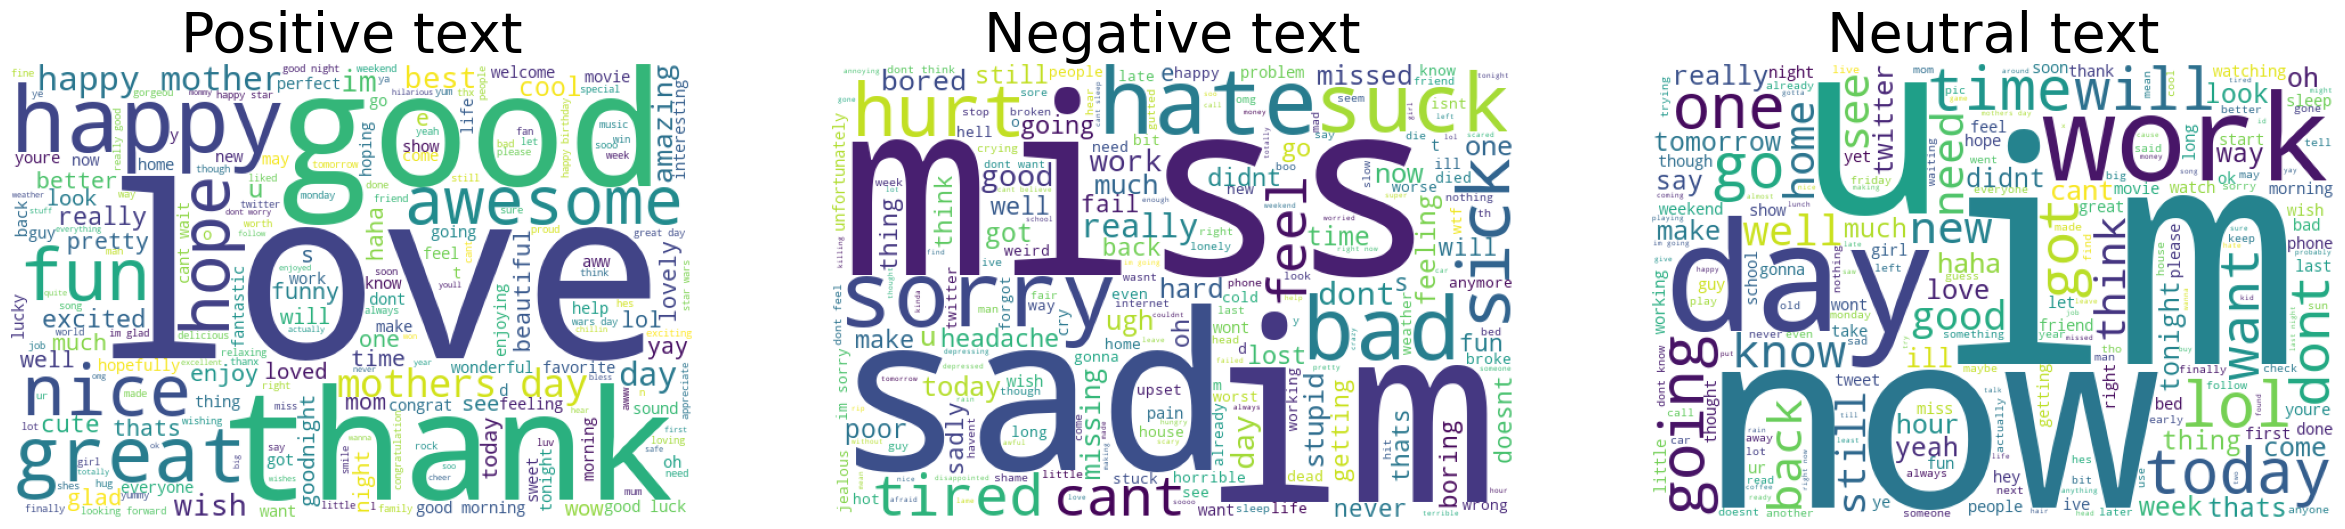

In [39]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);


The wordclouds give an idea of the words which might influence the polarity of the tweet.

# 9. Extracting the sentiment terms : Resources

There are a number of ways in which the problem can be approached and a lot of good solutions have been provided as notebooks which I would like to point out:

## 1. Question-Answering Starter pack

Here is a great solution by [Jonathan Besomi](https://www.kaggle.com/jonathanbesomi) provided in his notebook titled: [**Question-Answering Starter pack**](https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack/output) wherein he formulates the task as a question answering problem. He writes

*We formulate the task as question answering problem: given a question and a context, we train a transformer model to find the answer in the text column (the context).*

*We have:*

*Question: sentiment column (positive or negative)*
*Context: text column*
*Answer: selected_text column*


## 2. Sentiment Extraction using Bert 

[This](https://www.kaggle.com/abhishek/roberta-inference-5-folds) is kernel by [Abhishek Thakur](https://www.kaggle.com/abhishek/text-extraction-using-bert-w-sentiment-inference) which his based on his awesome videos on youtube where he live codes the entire problem solution. Be sure to check them out. 


In [38]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/XaQ0CBlQ4cY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# 10 : Sentiment Extraction using Bert

After going through the above resources, I decided to use Bert for the task. The normal Question Answering tasks typically have the following format:

- A Question 
- A Reference text which contains the answers

Here is an example from the famous [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/explore/v2.0/dev/Amazon_rainforest.html) dataset: ![](https://imgur.com/HqIzGO5.png)


Hence, the current problem can also be converted to a QA task wherein:

- Question == Sentiment column
- Reference Text == Text column 
- Answer == Selected Text column
  
**Selected text** column is a portion of the **text** column.Hence, it can be simply represented as START and END tokens.
![](https://imgur.com/u3WkjBP.png)

Therefore, our training data will consist of Text columns(concatenated Sentiment column and Text column) and labels will consist of the the start and end tokens of the selected text.


## 10.1 : Tokenization

Tokenizing the sentences using Bert Tokenizer from Hugging Face 🤗

In [39]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [40]:
# Tokenizing the first text
print(train['text'][10]) # original sentence
print(tokenizer.tokenize(train['text'][10], add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['text'][10])))

 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
['as', 'much', 'as', 'i', 'love', 'to', 'be', 'hopeful', ',', 'i', 'reckon', 'the', 'chances', 'are', 'minimal', '=', 'p', 'i', '`', 'm', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff']
[2004, 2172, 2004, 1045, 2293, 2000, 2022, 17772, 1010, 1045, 29072, 1996, 9592, 2024, 10124, 1027, 1052, 1045, 1036, 1049, 2196, 6069, 2131, 2026, 9850, 1998, 4933]


## 10.2 Preprocessing data for Bert

BERT expects input data in a specific format i.e
- Tokenized dataset
- All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the `text` and the `sentiment` column, the length should be decided by the concatanated text column.
- We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

*[From the Hugging face documentation](https://huggingface.co/transformers/glossary.html#attention-mask)
The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.
*
- Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]). 

   

In [41]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id

('[SEP]', 102)

('[CLS]', 101)

In [42]:
# calculating length of the longest text

max_len = 0

for text in train['text']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print('Max length: ', max_len)


Max length:  110


We shall take the maximum length to be 150 since we shall be concatenating text and sentiment columns. There is a very helpful function called [encode_plus](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus) provided in the Tokenizer class which can prove to be real handly. It can seamlessly perform the following operations:

- Tokenize the text
- Add special tokens - [CLS] and [SEP]
- create token IDs
- Pad the sentences to a common length
- Create attention masks for the above PAD tokens

In [43]:
text = train['text'].values
sentiment = train['sentiment'].values

input_ids = []
attention_masks = []
token_type_ids = []

for i in range(len(text)):
    encoded = tokenizer.encode_plus(
      sentiment[i],
      text[i],
      add_special_tokens=True,
      max_length=150,
      pad_to_max_length=True,
      return_token_type_ids=True,
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)

print('Original text: ',text[10])
print(len(input_ids[10]))
print(input_ids[10])
print(attention_masks[10])
print(token_type_ids[10])

Original text:   as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
150
tensor([  101,  8699,   102,  2004,  2172,  2004,  1045,  2293,  2000,  2022,
        17772,  1010,  1045, 29072,  1996,  9592,  2024, 10124,  1027,  1052,
         1045,  1036,  1049,  2196,  6069,  2131,  2026,  9850,  1998,  4933,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,

What we get are 3 tensors. Let me briefly go over them:

- 1) **input_ids** : list of token ids to be fed to a model. We can see that all token ids have been padded to a length of 150.
- 2) **attention_masks**:  list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.
- 3) **token_type_ids** :  list of token type ids to be fed to a model. These are also in the form of 0s and 1s and help to differentiate between the two sequences. The first sequence is the sentiment and the second is the text. Remember we had concatanated them. But why we need it? This is because the model has to differentiate between the two sequences and it will use these IDs to place a SEP token between them.

The last thing that we have to do before we begin training the model is to convert the selected text column as a combination of the START and END tokens. 

After going through a lot of resources, I think there is no point in reinventing the wheel. The following kernel from Abhishek clearly explains the whole process very well.

[BERT Base Uncased using PyTorch.](https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch)

## Other Notebooks in Getting started with NLP series

I have written a couple of other notebooks in getting started with NLP which some of you may find useful:

* [Getting started with NLP - A general Intro](https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro)

* [Getting started with NLP-Feature Vectors](https://www.kaggle.com/parulpandey/getting-started-with-nlp-feature-vectors)